In [2]:
import torch
import torch.optim as optim
from nf_loe.data import GenericDataset
from sklearn.datasets import load_digits
from nflows.flows.realnvp import SimpleRealNVP
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'torch'

In [8]:
# Digits
digits = load_digits(as_frame=True)
df_digits = digits['frame']
# df_digits = df_digits.loc[:, (df_digits != df_digits.iloc[0]).any()] 

data = GenericDataset(data_frame=df_digits, target_column='target')

In [3]:
num_flows = 5
num_variables = data[:]['sample'].shape[1]
num_channels = 1
actnorm = False
max_epochs = 800
batch_size = 1024
weight_decay = 1e-3
log_frequency = 50
lr = 1e-4

In [10]:
flow = SimpleRealNVP(
    features=num_variables,
    hidden_features=128,
    num_layers=20,
    num_blocks_per_layer=2,
    batch_norm_between_layers=True
)
optimizer = optim.Adam(flow.parameters())
    
loss_list = []
train_loader = DataLoader(data, batch_size=batch_size, shuffle=True)
for epoch in range(1, max_epochs+1):
    loss_all = torch.tensor(0, dtype=torch.float)
    for data_batch in train_loader:
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=data_batch['sample']).mean()
        loss.backward()
        optimizer.step()
        loss_all += loss.sum()
    loss_list.append(loss_all.item()/len(train_loader.dataset))
    if epoch % log_frequency == 0:
        print(f" - Epoch {epoch:3d}: {loss.item():.3f}")

 - Epoch  50: -76.011
 - Epoch 100: -91.580
 - Epoch 150: -107.643
 - Epoch 200: -131.293
 - Epoch 250: -132.395
 - Epoch 300: -139.041
 - Epoch 350: -135.268
 - Epoch 400: -138.373
 - Epoch 450: -146.088
 - Epoch 500: -152.355
 - Epoch 550: -153.182
 - Epoch 600: -146.042
 - Epoch 650: -152.275
 - Epoch 700: -150.025
 - Epoch 750: -163.410
 - Epoch 800: -167.203


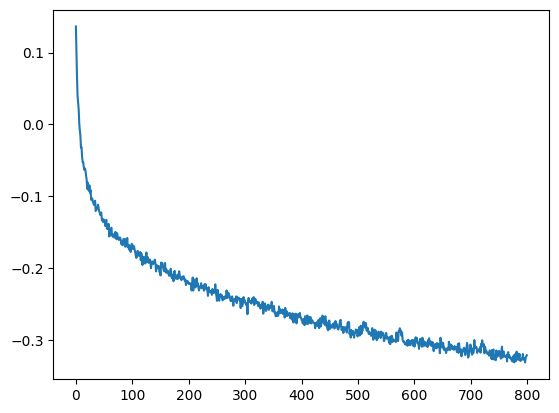

In [5]:
plt.plot(loss_list)

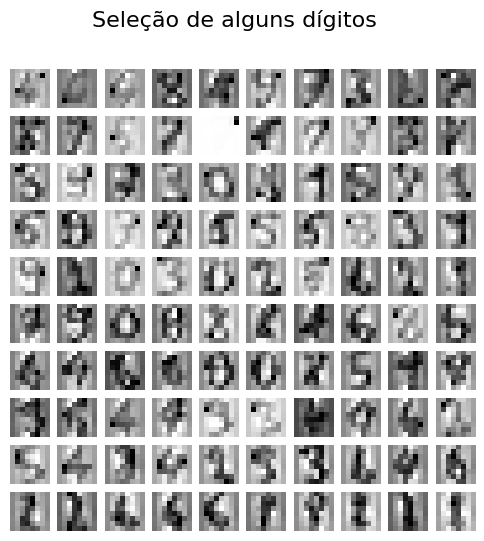

In [6]:
import numpy as np

flow.eval()
n_samples = 100
samples, log_prob = flow.sample_and_log_prob(n_samples)
images = samples[log_prob.argsort(), :].reshape(n_samples, 8, 8).detach().numpy()

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(images[idx, :, :], cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("Seleção de alguns dígitos", fontsize=16)